<a href="https://colab.research.google.com/github/muli2487/Twitter-Sentiment-Analysis-and-Bitcoin-Stock-Prediction/blob/master/Time_Series_Bitcoin_using_FBProphet%20with%20metrics%20and%20Box%20Cox%20Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series - Facebook Prophet

# Importing Libraries

In [0]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
import _pickle as pickle

from fbprophet import Prophet as proph

In [0]:
url = 'https://www.quandl.com/api/v3/datasets/BCHAIN/MKPRU.csv?api_key=Lq43ztbiWJ73CJUDPiye&start_date=2017-08-01&end_date=2020-5-29&order=asc'

## Loading in the Data

In [3]:
df= pd.read_csv(url)
df.head()

,Date,Value
0,2017-08-01,2866.431667
1,2017-08-02,2710.413067
2,2017-08-03,2693.633983
3,2017-08-04,2794.117717
4,2017-08-05,2873.851083


## Formatting the data for Facebook Prophet

In [4]:
# Resetting the index back so Dates are no longer indexed
#df.reset_index(inplace=True)

# Renaming the columns for use in FB prophet
df.rename(columns={'Date': 'ds', 'Value': 'y'}, inplace=True)

df.head()

,ds,y
0,2017-08-01,2866.431667
1,2017-08-02,2710.413067
2,2017-08-03,2693.633983
3,2017-08-04,2794.117717
4,2017-08-05,2873.851083


## Plotting the data

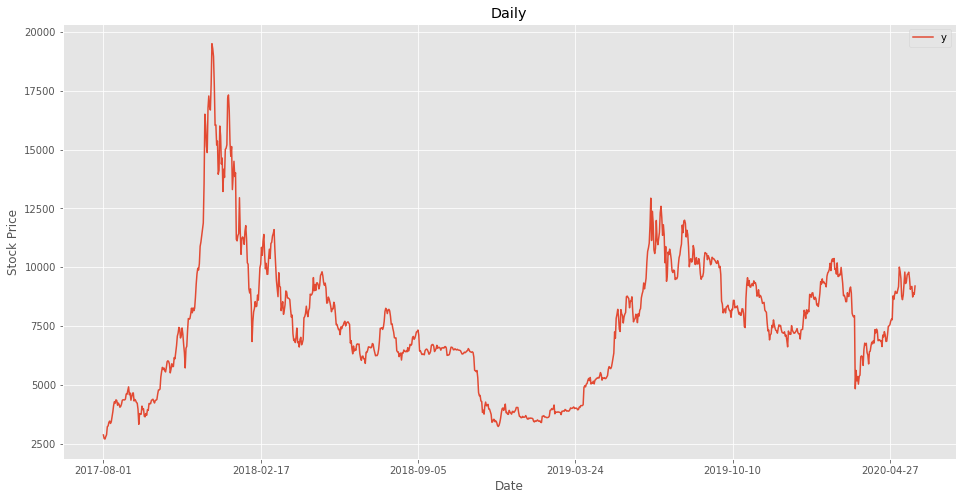

In [5]:
# Plotting the price 
pd.plotting.register_matplotlib_converters()

ax = df.set_index('ds').plot(figsize=(16,8))
ax.set_title("Daily")
ax.set_ylabel('Stock Price')
ax.set_xlabel('Date')

plt.show()

## To measure the quality of our forecast, we need to split our dataset into the historical part, which is the first and biggest slice of our data, and the prediction part, which will be located at the end of the timeline. We will remove the last month from the dataset in order to use it later as a prediction target:

In [6]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
1000,2020-04-27,7549.52
1001,2020-04-28,7699.27
1002,2020-04-29,7790.66


In [10]:
!pip install fbprophet

## Modeling

In [11]:
from fbprophet import Prophet
m = Prophet()
m.fit(train_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Using the helper method Prophet.make_future_dataframe, we create a dataframe which will contain all dates from the history and also extend into the future for those 30 days that we left out before.

In [12]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

,ds
1030,2020-05-27
1031,2020-05-28
1032,2020-05-29


In [13]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1030,2020-05-27,8854.197579,7534.993773,10536.243243,8700.432528,8943.617130,195.564845,195.564845,195.564845,13.706494,13.706494,13.706494,181.858350,181.858350,181.858350,0.0,0.0,0.0,9049.762424
1031,2020-05-28,8854.718854,7490.438075,10455.670492,8692.438506,8954.170701,134.427032,134.427032,134.427032,-8.537713,-8.537713,-8.537713,142.964745,142.964745,142.964745,0.0,0.0,0.0,8989.145886
1032,2020-05-29,8855.240128,7351.324252,10401.219907,8685.173064,8960.623442,99.691622,99.691622,99.691622,-5.284521,-5.284521,-5.284521,104.976143,104.976143,104.976143,0.0,0.0,0.0,8954.931750


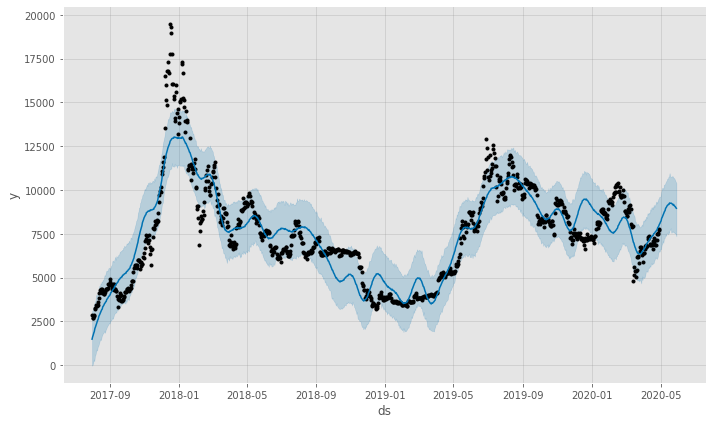

In [14]:
m.plot(forecast);

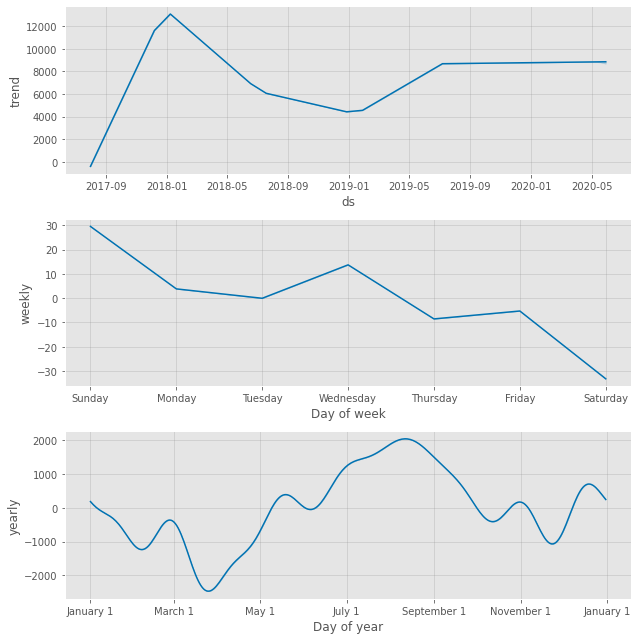

In [15]:
m.plot_components(forecast);

##  Forecast quality evaluation
Let's evaluate the quality of the algorithm by calculating the error metrics for the last 30 days that we predicted. For this, we will need the observations  yi  and the corresponding predicted values  y^i .

Let's look into the object forecast that the library created for us:

In [16]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [0]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [18]:
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2020-05-27,9049.762424,7534.993773,10536.243243,8899.66
2020-05-28,8989.145886,7490.438075,10455.670492,8842.85
2020-05-29,8954.931750,7351.324252,10401.219907,9197.54


In [0]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

# We are also going to define a helper function that we will use to gauge the quality of our forecasting with MAPE and MAE error measures:

In [0]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [23]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 4.020065203661515
MAE 370.80853537244394


#As a result, the relative error of our forecast (MAPE) is about 4.02%, and on average our model is wrong by 370.808 posts (MAE).

In [0]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

In [28]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="gray"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Price'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100,    'BitCoin Stock Prediction')

## At first glance, the prediction of the mean values by our model seems to be sensible. The high value of MAPE that we got above may be explained by the fact that the model failed to catch on to increasing peak-to-peak amplitude of weakly seasonality.

Also, we can conclude from the graph above that many of the actual values lie outside the confidence interval. Prophet may not be suitable for time series with unstable variance, at least when the default settings are used. We will try to fix this by applying a transform to our data.

## Box-Cox Transformation
So far we have used Prophet with the default settings and the original data. We will leave the parameters of the model alone. But despite this we still have some room for improvement. In this section, we will apply the Box–Cox transformation to our original series. Let's see where it will lead us.

A few words about this transformation. This is a monotonic data transformation that can be used to stabilize variance. We will use the one-parameter Box–Cox transformation, which is defined by the following expression:

boxcox(λ)(yi)=⎧⎩⎨yλi−1λln(yi),if λ≠0.,if λ=0.
 
We will need to implement the inverse of this function in order to be able to restore the original data scale. It is easy to see that the inverse is defined as:

invboxcox(λ)(yi)=⎧⎩⎨⎪⎪e(ln(λyi+1)λ)eyi,if λ≠0.,if λ=0.

In [0]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

First, we prepare our dataset by setting its index:

In [0]:
train_df2 = train_df.copy().set_index('ds')

Then, we apply the function stats.boxcox from Scipy, which applies the Box–Cox transformation. In our case it will return two values. The first one is the transformed series and the second one is the found value of  λ  that is optimal in terms of the maximum log-likelihood:

In [0]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

We create a new Prophet model and repeat the fit-predict cycle that we have already done above:

In [37]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


At this point, we need to revert the Box–Cox transformation with our inverse function and the known value of  λ :

In [0]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

Here we will reuse our tools for making the comparison dataframe and calculating the errors:

In [39]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 9.810305266248651
MAE 910.4813591883598


So, we can definitely state an increase in the quality of the model.

Finally, let's plot our previous performance with the latest results side-by-side. Note that we use prediction_size for the third parameter in order to zoom in on the interval being predicted:

In [40]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')

We see that the forecast of weekly changes in the second graph is much closer to the real values now.

# Summary
We have taken a look at Prophet, an open-source forecasting library that is specifically targeted at business time series. We have also done some hands-on practice in time series prediction.

As we have seen, the Prophet library does not make wonders, and its predictions out-of-box are not ideal. It is still up to the data scientist to explore the forecast results, tune model parameters and transform data when necessary.

However, this library is user-friendly and easily customizable. The sole ability to take into account abnormal days that are known to the analyst beforehand might make a difference in some cases.

All in all, the Prophet library is worth being a part of your analytical toolbox.